[Go to this directory index](./)

Contents
  - [Optimization method 2.5 parametric studies¶](#Optimization-method-2.5-parametric-studies)
      - [Trial 2.5¶](#Trial-2.5)
  - [Scratch work¶](#Scratch-work)

# Optimization method 2.5 parametric studies

Previously, I obtained reasonable convergence on optima using a two-step strategy: first, simply enforce feasibility and optimize cooling output without regard to cost; then for any given cooling output goal less than the maximum, enforce that as a constraint and optimize system cost (from size and flow parameters). With some art in selecting constraint functions, I implemented this using the COBYLA optimization routine.

Since that method can be made to work, let's do a parametric study in two parameters: temperature for heat rejection (T) and cost (UA). For each heat reject temperature, we will determine the maximum cooling (Q_max), then build a cost vs cooling curve. The data should form a surface of points (T,UA,Q). We can also visualize that surface by projecting and plotting isolines, for example, isolines of UA on a (T,Q) plot.

## Setup

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import matplotlib
import numpy
from IPython.display import HTML, SVG, clear_output

In [12]:
#matplotlib.use('svg')
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Arial'

In [13]:
from io import BytesIO
def pltsvg():
    imgdata = BytesIO()
    plt.savefig(imgdata)
    imgdata.seek(0)
    display(SVG(data=imgdata.read()))

In [14]:
import ammonia1
import system_aqua1
import scipy.optimize

In [15]:
def saturate(x, bottom=-numpy.inf, top=0):
    a_bottom = numpy.empty_like(x)
    a_top = numpy.empty_like(x)
    a_bottom.fill(bottom)
    a_top.fill(top)
    return numpy.minimum(a_top,
                         numpy.maximum(a_bottom,
                                       x))

def barrier1(c, length_scale):
    """The domain for B is the feasible set only.
    We want B large near boundary, but small elsewhere.
    Feasible means c > 0 and g < 0. Please input c.
    """
    g = numpy.negative(c)
    b = numpy.exp(g / length_scale)
    return numpy.sum(b)

def decay1(step_number, initial_value = 1., rate = 1.):
    """A decaying function to scale barrier functions.
    step_number: as this increases, I decay.
    initial_value: value when step_number = 0.
    decay_rate: how fast to decay.
    """
    # Magnitude tends to zero, slowly
    mu_B = initial_value * numpy.exp(-rate * step_number)
    return mu_B        

def penalty1(c, length_scale):
    """We want P = 0 for feasible, P > 0 elsewhere
    Feasible means c > 0 and g < 0.
    """
    g = numpy.negative(c)
    g = saturate(g,bottom=0,top=numpy.inf)
    p = (g / length_scale)**2
    return numpy.sum(p)

def grow1(step_number, initial_value = 1., rate = 1.):
    """A growing function to scale penalty functions."""
    # Magnitude tends to infinite, bit more quickly
    mu_P = initial_value * numpy.exp(rate * step_number)
    return mu_P


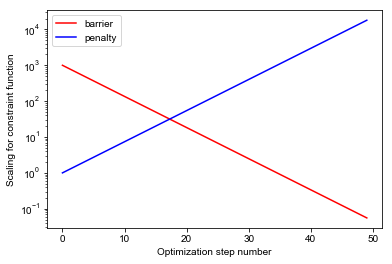

In [16]:
step_number = numpy.arange(50)
mu_B = decay1(step_number,initial_value=1000,rate=0.2)
mu_P = grow1(step_number,initial_value=1,rate=0.2)
plt.close('all')
plt.figure()
plt.semilogy(step_number,mu_B,'r',label='barrier')
plt.semilogy(step_number,mu_P,'b',label='penalty')
plt.xlabel('Optimization step number')
plt.ylabel('Scaling for constraint function')
plt.legend()
plt.show()

### Trial 2.5
An extension of a previous idea, kind of the dual problem -- Perform optimization in two steps: first with no constraint on UA (cost) to determine maximum Q (output). Then for each Q in a set of lesser values, optimize with respect to cost. This will deliver an optimal cost vs output curve.

For the first step, since we are not interested in UA, we can be less strict with the constraints on heat exchange feasibility. Specifically, we can impose them via penalty constraints instead of barrier constraints.

In [20]:
class Problem_2_5_A:
    def __init__(self, bdry, mu=0.1):
        self.bdry = bdry
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        print(xC,flush=True)
        Q,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T]                        
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [deltaT - 0.01
                         for name, deltaT, epsilon, UA, Qhx in sys.data]
            P = mu_P * penalty1(penalties,1)
            
            Q = sys.chiller.Q_evap
        except:
            Q = numpy.inf
        
        print(self.n_calls, step_number, Q, B, P, "\n", flush=True)
        return -Q + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [18]:
class Problem_2_5_B:
    def __init__(self, bdry, Q_goal, mu=0.1):
        self.bdry = bdry
        self.Q_goal = Q_goal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective_raw(self, xC):
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            UA = sys.totalUA
        except:
            UA = numpy.nan
        return UA

        
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        print(xC,flush=True)
        UA,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T] \
                       + [deltaT
                          for name, deltaT, epsilon, UA, Qhx in sys.data]
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [ch.Q_evap - self.Q_goal]
            P = mu_P * penalty1(penalties,1)
            
            UA = sys.totalUA
        except:
            UA = numpy.inf
        
        print(self.n_calls, step_number, UA, B, P, "\n", flush=True)
        return UA + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

## Parametric study across T_heat_reject

In [21]:
t_heat_reject_range = 273.15 + numpy.arange(20,61,5)

opts = []

for T_heat_reject in t_heat_reject_range:
    display("Now optimizing for T_heat_reject = ", T_heat_reject)
    rT = T_heat_reject
    xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
    bdry = system_aqua1.makeBoundary(xB)
    P = Problem_2_5_A(bdry)
    x = numpy.array([0.05, 278.45, rT+7, rT+8, rT+5, 395.15])
    opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':100,'rhobeg':0.1})
    x = opt.x
    display("First pass and we have this ... ")
    ch = system_aqua1.makeChiller(x)
    sys = system_aqua1.System(bdry, ch)
    display(sys)
    
    opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':100,'rhobeg':0.01})
    x = opt.x
    display("Second pass and we have this ... ")
    ch = system_aqua1.makeChiller(x)
    sys = system_aqua1.System(bdry, ch)
    display(sys)
    
    opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':100,'rhobeg':0.001})
    display("Third pass and we have this ... ")
    ch = system_aqua1.makeChiller(x)
    sys = system_aqua1.System(bdry, ch)
    display(sys)
    
    opts.append(opt)

'Now optimizing for T_heat_reject = '

293.14999999999998

[  5.00000000e-02   2.78450000e+02   3.00150000e+02   3.01150000e+02
   2.98150000e+02   3.95150000e+02]


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


1 0.0 29.3426607866 1.2297733705e-07 0.252489920282 

[  1.50000000e-01   2.78450000e+02   3.00150000e+02   3.01150000e+02
   2.98150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
2 0.0 88.0279823597 1.2297733705e-07 0.252491105531 

[  1.50000000e-01   2.78550000e+02   3.00150000e+02   3.01150000e+02
   2.98150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
3 0.0 88.2479969814 1.38611675433e-07 0.236281170674 

[  1.50000000e-01   2.78550000e+02   3.00250000e+02   3.01150000e+02
   2.98150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
4 0.0 88.1631796043 1.23799988712e-07 0.224909214211 

[  1.50000000e-01   2.78550000e+02   3.00150000e+02   3.01250000e+02
   2.98150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
5 0.0 88.2479969814 1.53189592595e-07 0.236281170674 

[  1.50000000e-01   2.78550000e+02   3.00150000e+02   3.01150000e+02
   2.98250000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
6 0.0 88.0413347742 1.2435634002

Note: Absorber inlet is subcooled
44 6.0 205.978442639 1.09339638391e-15 164.671004124 

[  3.49977359e-01   2.78550804e+02   3.00149769e+02   3.01149954e+02
   2.98149540e+02   3.95250239e+02]
Note: Absorber inlet is subcooled
45 6.0 206.020959724 1.09273591579e-15 164.875632384 

[  3.50150066e-01   2.78550873e+02   3.00149685e+02   3.01150082e+02
   2.98149523e+02   3.95250131e+02]
Note: Absorber inlet is subcooled
46 6.0 206.123105873 1.0933795324e-15 165.391149828 

[  3.49986967e-01   2.78550735e+02   3.00149738e+02   3.01150007e+02
   2.98149548e+02   3.95250105e+02]
Note: Absorber inlet is subcooled
47 6.0 206.026126911 1.09272773893e-15 164.898396901 

[  3.50020899e-01   2.78550808e+02   3.00149769e+02   3.01149972e+02
   2.98149502e+02   3.95250147e+02]
Note: Absorber inlet is subcooled
48 6.0 206.046682914 1.0928606621e-15 165.004560171 

[  3.49965228e-01   2.78550826e+02   3.00149800e+02   3.01150075e+02
   2.98149508e+02   3.95250167e+02]
Note: Absorber inlet is subcoole

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.75016,0.955469,25.3018,288.195
rect,7.41571,0.745722,1.66268,13.6327
abs,-1.57657,1.07552,inf,281.485
cond,-2.11486,1.2847,inf,199.409
evap,-4.48621,1.57236,inf,206.014
total,0,0,inf,0


[  3.49965228e-01   2.78550826e+02   3.00149800e+02   3.01150075e+02
   2.98149508e+02   3.95250167e+02]
Note: Absorber inlet is subcooled
50 7.0 206.013944976 1.41129819283e-17 222.512818459 

[  3.59965228e-01   2.78550826e+02   3.00149800e+02   3.01150075e+02
   2.98149508e+02   3.95250167e+02]
Note: Absorber inlet is subcooled
51 7.0 211.900642529 1.41129819283e-17 264.092428717 

[  3.49965228e-01   2.78560826e+02   3.00149800e+02   3.01150075e+02
   2.98149508e+02   3.95250167e+02]
Note: Absorber inlet is subcooled
52 7.0 206.065320972 1.4457143275e-17 223.581500323 

[  3.49965228e-01   2.78550826e+02   3.00159800e+02   3.01150075e+02
   2.98149508e+02   3.95250167e+02]
Note: Absorber inlet is subcooled
53 7.0 205.994183147 1.37954536983e-17 221.998872227 

[  3.49965228e-01   2.78550826e+02   3.00159800e+02   3.01160075e+02
   2.98149508e+02   3.95250167e+02]
Note: Absorber inlet is subcooled
54 7.0 205.994183147 1.40760760577e-17 221.998872227 

[  3.49965228e-01   2.78550826e

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.75012,0.955448,25.3313,288.18
rect,7.40358,0.746322,1.66766,13.6536
abs,-1.56581,1.07497,inf,281.465
cond,-2.10331,1.28279,inf,199.361
evap,-4.48434,1.57212,inf,205.983
total,0,0,inf,0


[  3.50027102e-01   2.78550839e+02   3.00159744e+02   3.01150111e+02
   2.98159517e+02   3.95250207e+02]
Note: Absorber inlet is subcooled
89 12.0 205.982507789 1.73963807605e-30 993.58118148 

[  3.51027102e-01   2.78550839e+02   3.00159744e+02   3.01150111e+02
   2.98159517e+02   3.95250207e+02]
Note: Absorber inlet is subcooled
90 12.0 206.570983671 1.73963807605e-30 1011.35656184 

[  3.50027102e-01   2.78551839e+02   3.00159744e+02   3.01150111e+02
   2.98159517e+02   3.95250207e+02]
Note: Absorber inlet is subcooled
91 12.0 205.987644618 1.74656284156e-30 994.059059681 

[  3.50027102e-01   2.78550839e+02   3.00160744e+02   3.01150111e+02
   2.98159517e+02   3.95250207e+02]
Note: Absorber inlet is subcooled
92 13.0 205.980530898 6.21308156786e-34 1340.88425188 

[  3.50027102e-01   2.78550839e+02   3.00159744e+02   3.01151111e+02
   2.98159517e+02   3.95250207e+02]
Note: Absorber inlet is subcooled
93 13.0 205.982507789 6.26183251254e-34 1341.19430886 

[  3.50027102e-01   2.7855

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.75012,0.955448,25.3313,288.18
rect,7.40358,0.746322,1.66766,13.6536
abs,-1.56581,1.07497,inf,281.465
cond,-2.10331,1.28279,inf,199.361
evap,-4.48434,1.57212,inf,205.983
total,0,0,inf,0


'Now optimizing for T_heat_reject = '

298.14999999999998

[  5.00000000e-02   2.78450000e+02   3.05150000e+02   3.06150000e+02
   3.03150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
1 0.0 24.5883547239 2.53601663205e-10 0.389515764271 

[  1.50000000e-01   2.78450000e+02   3.05150000e+02   3.06150000e+02
   3.03150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
2 0.0 73.7650641718 2.53601663205e-10 0.389517255888 

[  1.50000000e-01   2.78550000e+02   3.05150000e+02   3.06150000e+02
   3.03150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
3 0.0 73.9673270767 2.86885056538e-10 0.388044771002 

[  1.50000000e-01   2.78550000e+02   3.05250000e+02   3.06150000e+02
   3.03150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
4 0.0 73.8724667435 2.55549967033e-10 0.365433586636 

[  1.50000000e-01   2.78550000e+02   3.05150000e+02   3.06250000e+02
   3.03150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
5 0.0 73.9673270767 3.17057021316e-10 0.388044771002 

[  1.50000000e-01   2.78550000

[  3.49878541e-01   2.78551013e+02   3.05149761e+02   3.06149361e+02
   3.03149399e+02   3.95249921e+02]
Note: Absorber inlet is subcooled
44 6.0 172.675746119 1.40500904498e-20 42.9962475036 

[  3.49347501e-01   2.78550723e+02   3.05149442e+02   3.06150144e+02
   3.03149952e+02   3.95250220e+02]
Note: Absorber inlet is subcooled
45 6.0 172.411008604 1.40548450487e-20 42.4037417892 

[  3.50045949e-01   2.78550790e+02   3.05149957e+02   3.06149922e+02
   3.03149941e+02   3.95250208e+02]
Note: Absorber inlet is subcooled
46 6.0 172.754915856 1.40363032429e-20 43.1586143274 

[  3.49963225e-01   2.78550696e+02   3.05149784e+02   3.06150040e+02
   3.03149589e+02   3.95250127e+02]
Note: Absorber inlet is subcooled
47 6.0 172.715449615 1.40514269512e-20 43.072715175 

[  3.50086811e-01   2.78550684e+02   3.05149544e+02   3.06149849e+02
   3.03149643e+02   3.95250482e+02]
Note: Absorber inlet is subcooled
48 6.0 172.77716933 1.40517393034e-20 43.2107275324 

[  3.49871633e-01   2.78550915e+

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,3.31232,0.948367,32.0367,254.244
rect,7.65472,0.765519,1.5969,15.6492
abs,-0.724636,1.03836,inf,245.941
cond,-0.547768,1.07415,inf,165.793
evap,-2.49517,1.31833,inf,172.732
total,0,0,inf,0


[  3.49996285e-01   2.78550784e+02   3.05149660e+02   3.06149998e+02
   3.03149631e+02   3.95250280e+02]
Note: Absorber inlet is subcooled
55 7.0 172.732480043 5.55223482801e-23 58.1975804034 

[  3.59996285e-01   2.78550784e+02   3.05149660e+02   3.06149998e+02
   3.03149631e+02   3.95250280e+02]
Note: Absorber inlet is subcooled
56 7.0 177.667746147 5.55223482801e-23 74.1538354282 

[  3.49996285e-01   2.78560784e+02   3.05149660e+02   3.06149998e+02
   3.03149631e+02   3.95250280e+02]
Note: Absorber inlet is subcooled
57 8.0 172.779693175 1.25961059319e-25 79.3042709847 

[  3.49996285e-01   2.78550784e+02   3.05159660e+02   3.06149998e+02
   3.03149631e+02   3.95250280e+02]
Note: Absorber inlet is subcooled
58 8.0 172.710379521 1.19437773575e-25 78.3169377002 

[  3.49996285e-01   2.78550784e+02   3.05149660e+02   3.06159998e+02
   3.03149631e+02   3.95250280e+02]
Note: Absorber inlet is subcooled
59 8.0 172.732480043 1.25309997767e-25 78.5585164871 

[  3.49996285e-01   2.78550784

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,3.30229,0.948523,32.0672,254.286
rect,7.65453,0.765551,1.59745,15.6517
abs,-0.725017,1.03837,inf,245.982
cond,-0.549047,1.07433,inf,165.821
evap,-2.49692,1.31856,inf,172.761
total,0,0,inf,0


[  3.50053990e-01   2.78550804e+02   3.05149674e+02   3.06150017e+02
   3.03149556e+02   3.95250277e+02]
Note: Absorber inlet is subcooled
87 12.0 172.76134515 2.29522614709e-39 261.216621066 

[  3.51053990e-01   2.78550804e+02   3.05149674e+02   3.06150017e+02
   3.03149556e+02   3.95250277e+02]
Note: Absorber inlet is subcooled
88 12.0 173.254872862 2.29522614709e-39 267.883072118 

[  3.50053990e-01   2.78551804e+02   3.05149674e+02   3.06150017e+02
   3.03149556e+02   3.95250277e+02]
Note: Absorber inlet is subcooled
89 12.0 172.766066867 2.30464042271e-39 261.463860369 

[  3.50053990e-01   2.78550804e+02   3.05150674e+02   3.06150017e+02
   3.03149556e+02   3.95250277e+02]
Note: Absorber inlet is subcooled
90 12.0 172.759134848 2.28642962756e-39 261.135854633 

[  3.50053990e-01   2.78550804e+02   3.05150674e+02   3.06151017e+02
   3.03149556e+02   3.95250277e+02]
Note: Absorber inlet is subcooled
91 12.0 172.759134848 2.29403345707e-39 261.135854633 

[  3.50053990e-01   2.7855

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,3.30229,0.948523,32.0672,254.286
rect,7.65453,0.765551,1.59745,15.6517
abs,-0.725017,1.03837,inf,245.982
cond,-0.549047,1.07433,inf,165.821
evap,-2.49692,1.31856,inf,172.761
total,0,0,inf,0


'Now optimizing for T_heat_reject = '

303.14999999999998

[  5.00000000e-02   2.78450000e+02   3.10150000e+02   3.11150000e+02
   3.08150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
1 0.0 19.9331400856 4.22011043211e-13 0.0 

[  1.50000000e-01   2.78450000e+02   3.10150000e+02   3.11150000e+02
   3.08150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
2 0.0 59.7994202567 4.22011043211e-13 0.0 

[  1.50000000e-01   2.78550000e+02   3.10150000e+02   3.11150000e+02
   3.08150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
3 0.0 59.99131292 4.79120910057e-13 0.0 

[  1.50000000e-01   2.78550000e+02   3.10250000e+02   3.11150000e+02
   3.08150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
4 0.0 59.8837069901 4.25435902709e-13 0.0 

[  1.50000000e-01   2.78550000e+02   3.10150000e+02   3.11250000e+02
   3.08150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
5 0.0 59.99131292 5.29510496037e-13 0.0 

[  1.50000000e-01   2.78550000e+02   3.10150000e+02   3.11150000e+02
   3.08250000e+02   

Note: Absorber inlet is subcooled
44 6.0 145.528887054 1.5390030199e-25 7.61094397083 

[  3.61965465e-01   2.78599797e+02   3.10149350e+02   3.11150396e+02
   3.08092762e+02   3.95250800e+02]
Note: Absorber inlet is subcooled
45 6.0 145.4054261 1.539699918e-25 7.1874529845 

[  3.61728739e-01   2.78600073e+02   3.10149403e+02   3.11150120e+02
   3.08092782e+02   3.95250620e+02]
Note: Absorber inlet is subcooled
46 6.0 145.311091123 1.5396679604e-25 6.88359649825 

[  3.61843898e-01   2.78599853e+02   3.10149658e+02   3.11150344e+02
   3.08092777e+02   3.95250852e+02]
Note: Absorber inlet is subcooled
47 6.0 145.356086959 1.53867983871e-25 7.0292448635 

[  3.61903957e-01   2.78599869e+02   3.10149512e+02   3.11150377e+02
   3.08092834e+02   3.95250717e+02]
Note: Absorber inlet is subcooled
48 6.0 145.38019865 1.53913725804e-25 7.10666729315 

[  3.61930020e-01   2.78599890e+02   3.10149540e+02   3.11150388e+02
   3.08092601e+02   3.95250677e+02]
Note: Absorber inlet is subcooled
49 6.

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,-0.581924,1.01086,inf,226.347
rect,7.79769,0.781721,1.51159,17.5053
abs,0.189275,0.990148,156.278,216.476
cond,0.732725,0.968492,55.047,138.309
evap,-0.910191,1.11685,inf,145.421
total,0,0,inf,0


[  3.62006107e-01   2.78599851e+02   3.10149539e+02   3.11150300e+02
   3.08092774e+02   3.95250757e+02]
Note: Absorber inlet is subcooled
53 7.0 145.421401902 1.82865709692e-28 9.77593661614 

[  3.72006107e-01   2.78599851e+02   3.10149539e+02   3.11150300e+02
   3.08092774e+02   3.95250757e+02]
Note: Absorber inlet is subcooled
54 7.0 149.438499928 1.82865709692e-28 46.6041790193 

[  3.62006107e-01   2.78609851e+02   3.10149539e+02   3.11150300e+02
   3.08092774e+02   3.95250757e+02]
Note: Absorber inlet is subcooled
55 7.0 145.467785791 1.87596920013e-28 9.96080027003 

[  3.62006107e-01   2.78599851e+02   3.10159539e+02   3.11150300e+02
   3.08092774e+02   3.95250757e+02]
Note: Absorber inlet is subcooled
56 7.0 145.395931487 1.78556254099e-28 9.78339149539 

[  3.62006107e-01   2.78599851e+02   3.10149539e+02   3.11160300e+02
   3.08092774e+02   3.95250757e+02]
Note: Absorber inlet is subcooled
57 8.0 145.421401902 1.09412743751e-31 13.1961341436 

[  3.62006107e-01   2.78599851

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.832811,0.984458,47.7568,220.453
rect,7.80622,0.777037,1.43898,17.0534
abs,0.185572,0.99034,143.456,210.841
cond,0.900392,0.968491,49.386,134.706
evap,-0.683748,1.08778,inf,141.639
total,0,0,inf,0


[  3.52560560e-01   2.78599696e+02   3.10149460e+02   3.11144584e+02
   3.08088902e+02   3.95248571e+02]
Note: Absorber inlet is subcooled
90 12.0 141.638760316 2.08768323121e-48 17.6142279743 

[  3.53560560e-01   2.78599696e+02   3.10149460e+02   3.11144584e+02
   3.08088902e+02   3.95248571e+02]
Note: Absorber inlet is subcooled
91 12.0 142.040503382 2.08768323121e-48 18.8557833025 

[  3.52560560e-01   2.78600696e+02   3.10149460e+02   3.11144584e+02
   3.08088902e+02   3.95248571e+02]
Note: Absorber inlet is subcooled
92 13.0 141.643277719 9.80818340033e-54 23.8635679508 

[  3.52560560e-01   2.78599696e+02   3.10150460e+02   3.11144584e+02
   3.08088902e+02   3.95248571e+02]
Note: Absorber inlet is subcooled
93 13.0 141.636279901 9.72030811434e-54 23.7665506601 

[  3.52560560e-01   2.78599696e+02   3.10149460e+02   3.11145584e+02
   3.08088902e+02   3.95248571e+02]
Note: Absorber inlet is subcooled
94 13.0 141.638760316 9.79852615163e-54 23.7767207697 

[  3.52560560e-01   2.785

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.832811,0.984458,47.7568,220.453
rect,7.80622,0.777037,1.43898,17.0534
abs,0.185572,0.99034,143.456,210.841
cond,0.900392,0.968491,49.386,134.706
evap,-0.683748,1.08778,inf,141.639
total,0,0,inf,0


'Now optimizing for T_heat_reject = '

308.14999999999998

[  5.00000000e-02   2.78450000e+02   3.15150000e+02   3.16150000e+02
   3.13150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
1 0.0 15.2618651202 5.5992673844e-16 0.0 

[  1.50000000e-01   2.78450000e+02   3.15150000e+02   3.16150000e+02
   3.13150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
2 0.0 45.7855953606 5.5992673844e-16 0.0 

[  1.50000000e-01   2.78550000e+02   3.15150000e+02   3.16150000e+02
   3.13150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
3 0.0 45.9716522196 6.38052895404e-16 0.0 

[  1.50000000e-01   2.78550000e+02   3.15250000e+02   3.16150000e+02
   3.13150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
4 0.0 45.8534097791 5.65037246087e-16 0.0 

[  1.50000000e-01   2.78550000e+02   3.15150000e+02   3.16250000e+02
   3.13150000e+02   3.95150000e+02]
Note: Absorber inlet is subcooled
5 0.0 45.9716522196 7.05157504194e-16 0.0 

[  1.50000000e-01   2.78550000e+02   3.15150000e+02   3.16150000e+02
   3.13250000e+02 

44 6.0 110.251374984 9.01493761798e-31 2.27346837418 

[  3.57502427e-01   2.78596721e+02   3.15144512e+02   3.16154193e+02
   3.13092545e+02   3.95250513e+02]
Note: Absorber inlet is subcooled
45 6.0 110.208210719 9.00825217893e-31 2.15579480626 

[  3.57903121e-01   2.78596471e+02   3.15144523e+02   3.16154359e+02
   3.13092602e+02   3.95250728e+02]
Note: Absorber inlet is subcooled
46 6.0 110.330784353 9.00436258977e-31 2.51384982829 

[  3.57774248e-01   2.78596731e+02   3.15144617e+02   3.16154128e+02
   3.13092553e+02   3.95250486e+02]
Note: Absorber inlet is subcooled
47 6.0 110.291672398 9.00517300147e-31 2.39476728756 

[  3.57680701e-01   2.78596615e+02   3.15144504e+02   3.16154233e+02
   3.13092516e+02   3.95250467e+02]
Note: Absorber inlet is subcooled
48 6.0 110.262749885 9.00737642281e-31 2.31084193205 

[  3.57726659e-01   2.78596816e+02   3.15144444e+02   3.16154354e+02
   3.13092522e+02   3.95250516e+02]
Note: Absorber inlet is subcooled
49 6.0 110.278048518 9.0147312

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,-0.609451,1.01401,inf,184.3
rect,7.92781,0.805749,1.18625,17.4351
abs,2.26299,0.891938,30.5683,173.929
cond,2.3339,0.969131,25.3662,103.831
evap,1.19597,0.983613,31.3936,110.267
total,0,0,inf,0


[  3.57692084e-01   2.78596701e+02   3.15144454e+02   3.16154181e+02
   3.13092447e+02   3.95250530e+02]
Note: Absorber inlet is subcooled
53 7.0 110.267168954 3.01547655018e-34 3.13351983936 

[  3.67692084e-01   2.78596701e+02   3.15144454e+02   3.16154181e+02
   3.13092447e+02   3.95250530e+02]
Note: Absorber inlet is subcooled
54 7.0 113.349908943 3.01547655018e-34 26.6230771446 

[  3.57692084e-01   2.78606701e+02   3.15144454e+02   3.16154181e+02
   3.13092447e+02   3.95250530e+02]
Note: Absorber inlet is subcooled
55 7.0 110.311577596 3.09579597539e-34 3.13981344103 

[  3.57692084e-01   2.78606701e+02   3.15154454e+02   3.16154181e+02
   3.13092447e+02   3.95250530e+02]
Note: Absorber inlet is subcooled
56 7.0 110.283466831 3.0209886186e-34 3.14867403322 

[  3.57692084e-01   2.78606701e+02   3.15144454e+02   3.16164181e+02
   3.13092447e+02   3.95250530e+02]
Note: Absorber inlet is subcooled
57 8.0 110.311577596 4.57855821634e-38 4.23830482753 

[  3.57692084e-01   2.78606701e

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,-0.0530863,1.00122,inf,181.956
rect,7.92549,0.805794,1.16195,17.2088
abs,2.25501,0.892278,29.9654,171.724
cond,2.39395,0.969131,24.7664,102.532
evap,1.26581,0.983638,30.4171,108.889
total,0,0,inf,0


[  3.53018288e-01   2.78609378e+02   3.15144314e+02   3.16150978e+02
   3.13088995e+02   3.95246901e+02]
Note: Absorber inlet is subcooled
94 13.0 108.888799921 3.03959309172e-64 0.196615997009 

[  3.54018288e-01   2.78609378e+02   3.15144314e+02   3.16150978e+02
   3.13088995e+02   3.95246901e+02]
Note: Absorber inlet is subcooled
95 13.0 109.197250796 3.03959309172e-64 1.63054740757 

[  3.53018288e-01   2.78610378e+02   3.15144314e+02   3.16150978e+02
   3.13088995e+02   3.95246901e+02]
Note: Absorber inlet is subcooled
96 13.0 108.893183387 3.0541865285e-64 0.196891809522 

[  3.53018288e-01   2.78610378e+02   3.15145314e+02   3.16150978e+02
   3.13088995e+02   3.95246901e+02]
Note: Absorber inlet is subcooled
97 13.0 108.890409291 3.04060455757e-64 0.197529805353 

[  3.53018288e-01   2.78610378e+02   3.15144314e+02   3.16151978e+02
   3.13088995e+02   3.95246901e+02]
Note: Absorber inlet is subcooled
98 13.0 108.893183387 3.0654138305e-64 0.196891809522 

[  3.53018288e-01   2.7

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,-0.0530863,1.00122,inf,181.956
rect,7.92549,0.805794,1.16195,17.2088
abs,2.25501,0.892278,29.9654,171.724
cond,2.39395,0.969131,24.7664,102.532
evap,1.26581,0.983638,30.4171,108.889
total,0,0,inf,0


'Now optimizing for T_heat_reject = '

313.14999999999998

[  5.00000000e-02   2.78450000e+02   3.20150000e+02   3.21150000e+02
   3.18150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
1 0.0 10.4857914382 5.85398544075e-19 0.0 

[  1.50000000e-01   2.78450000e+02   3.20150000e+02   3.21150000e+02
   3.18150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
2 0.0 31.4573743146 5.85398544075e-19 0.0 

[  1.50000000e-01   2.78550000e+02   3.20150000e+02   3.21150000e+02
   3.18150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
3 0.0 31.6407202325 6.69555373482e-19 0.0 

[  1.50000000e-01   2.78550000e+02   3.20250000e+02   3.21150000e+02
   3.18150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
4 0.0 31.508103866 5.90999762519e-19 0.0 

[  1.50000000e-01   2.78550000e+02   3.20150000e+02   3.21250000e+02
   3.18150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
5 0.0 31.6407202325 7.39973126814e-19 0.0 

[  1.50000000e-01   2.78550000e+02   3.2015000

[  3.60642581e-01   2.78602647e+02   3.20148120e+02   3.21158240e+02
   3.18089964e+02   3.95250479e+02]
Note: Absorber inlet contains some vapor.
43 6.0 76.7682731262 3.44301014964e-36 1.91785465963 

[  3.60783674e-01   2.78601653e+02   3.20148173e+02   3.21158159e+02
   3.18090141e+02   3.95250093e+02]
Note: Absorber inlet contains some vapor.
44 6.0 76.7922005406 3.43245338454e-36 1.99604989251 

[  3.60601235e-01   2.78602234e+02   3.20147790e+02   3.21158568e+02
   3.18089988e+02   3.95250469e+02]
Note: Absorber inlet contains some vapor.
45 6.0 76.7585879282 3.44400411373e-36 1.89366816263 

[  3.60493091e-01   2.78602268e+02   3.20148039e+02   3.21158259e+02
   3.18089872e+02   3.95250384e+02]
Note: Absorber inlet contains some vapor.
46 6.0 76.7351783743 3.44124272116e-36 1.83178772906 

[  3.60408157e-01   2.78602213e+02   3.20148155e+02   3.21158281e+02
   3.18090235e+02   3.95250674e+02]
Note: Absorber inlet contains some vapor.
47 6.0 76.7157564176 3.43739825796e-36 1.7856

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,-0.550401,1.01652,inf,142.443
rect,7.972,0.838672,0.844707,15.7756
abs,4.94,0.768676,14.8593,132.702
cond,3.83782,0.966691,13.8775,71.483
evap,3.19484,0.983432,14.935,76.7603
total,0,0,inf,0


[  3.60611936e-01   2.78602340e+02   3.20148110e+02   3.21158254e+02
   3.18090004e+02   3.95250483e+02]
Note: Absorber inlet contains some vapor.
54 7.0 76.7602880142 3.10003557057e-40 2.56458336611 

[  3.70611936e-01   2.78602340e+02   3.20148110e+02   3.21158254e+02
   3.18090004e+02   3.95250483e+02]
Note: Absorber inlet contains some vapor.
55 7.0 78.8888999733 3.10003557057e-40 16.1532691133 

[  3.60611936e-01   2.78612340e+02   3.20148110e+02   3.21158254e+02
   3.18090004e+02   3.95250483e+02]
Note: Absorber inlet contains some vapor.
56 7.0 76.8043917951 3.18498225899e-40 2.57974354035 

[  3.60611936e-01   2.78612340e+02   3.20158110e+02   3.21158254e+02
   3.18090004e+02   3.95250483e+02]
Note: Absorber inlet contains some vapor.
57 8.0 76.7726123646 1.051026832e-44 3.47637542026 

[  3.60611936e-01   2.78612340e+02   3.20148110e+02   3.21168254e+02
   3.18090004e+02   3.95250483e+02]
Note: Absorber inlet contains some vapor.
58 8.0 76.8043917951 1.10493102634e-44 3.482289

[  3.54453806e-01   2.78616798e+02   3.20145541e+02   3.21159241e+02
   3.18086972e+02   3.95252991e+02]
Note: Absorber inlet contains some vapor.
95 13.0 75.5371203917 3.86701033513e-75 0.0985535840012 

[  3.54424226e-01   2.78616753e+02   3.20145624e+02   3.21159237e+02
   3.18086984e+02   3.95253087e+02]
Note: Absorber inlet contains some vapor.
96 13.0 75.5305277893 3.86441958787e-75 0.0881600771552 



'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,-0.0322437,1.00101,inf,140.106
rect,7.97359,0.838509,0.824804,15.5098
abs,4.93698,0.768883,14.516,130.53
cond,3.88799,0.966702,13.5733,70.341
evap,3.25406,0.98346,14.5966,75.5305
total,0,0,inf,0


[  3.54424226e-01   2.78616753e+02   3.20145624e+02   3.21159237e+02
   3.18086984e+02   3.95253087e+02]
Note: Absorber inlet contains some vapor.
97 13.0 75.5305277893 3.86441958787e-75 0.0881600771552 

[  3.55424226e-01   2.78616753e+02   3.20145624e+02   3.21159237e+02
   3.18086984e+02   3.95253087e+02]
Note: Absorber inlet contains some vapor.
98 13.0 75.7436354785 3.86441958787e-75 0.794818700808 

[  3.54424226e-01   2.78617753e+02   3.20145624e+02   3.21159237e+02
   3.18086984e+02   3.95253087e+02]
Note: Absorber inlet contains some vapor.
99 14.0 75.5348627673 2.80453547771e-83 0.119789814739 

[  3.54424226e-01   2.78616753e+02   3.20146624e+02   3.21159237e+02
   3.18086984e+02   3.95253087e+02]
Note: Absorber inlet contains some vapor.
100 14.0 75.5274050473 2.77523784465e-83 0.118860971066 

[  3.54424226e-01   2.78616753e+02   3.20145624e+02   3.21160237e+02
   3.18086984e+02   3.95253087e+02]
Note: Absorber inlet contains some vapor.
101 14.0 75.5305277893 2.8006446476

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,-0.0322437,1.00101,inf,140.106
rect,7.97359,0.838509,0.824804,15.5098
abs,4.93698,0.768883,14.516,130.53
cond,3.88799,0.966702,13.5733,70.341
evap,3.25406,0.98346,14.5966,75.5305
total,0,0,inf,0


'Now optimizing for T_heat_reject = '

318.14999999999998

[  5.00000000e-02   2.78450000e+02   3.25150000e+02   3.26150000e+02
   3.23150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
1 0.0 5.51897762569 4.76731010584e-22 0.0 

[  1.50000000e-01   2.78450000e+02   3.25150000e+02   3.26150000e+02
   3.23150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
2 0.0 16.5569328771 4.76731010584e-22 0.0 

[  1.50000000e-01   2.78550000e+02   3.25150000e+02   3.26150000e+02
   3.23150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
3 0.0 16.7399188614 5.47242813426e-22 0.0 

[  1.50000000e-01   2.78550000e+02   3.25250000e+02   3.26150000e+02
   3.23150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
4 0.0 16.5897806846 4.81301822557e-22 0.0 

[  1.50000000e-01   2.78550000e+02   3.25150000e+02   3.26250000e+02
   3.23150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
5 0.0 16.7399188614 6.04796842524e-22 0.0 

[  1.50000000e-01   2.78550000e+02   3.251500

44 6.0 45.2336897382 8.05401922122e-42 2.96879281878 

[   0.39882773  278.60508498  325.14579891  326.14998611  323.09565296
  395.22771245]
Note: Absorber inlet contains some vapor.
45 6.0 45.2455368626 8.06257177688e-42 3.00438672514 

[   0.3988875   278.60543133  325.14608115  326.15002019  323.09586908
  395.22787396]
Note: Absorber inlet contains some vapor.
46 6.0 45.2524578167 8.06107313466e-42 3.029774206 

[   0.39909197  278.60493147  325.14611004  326.14982048  323.09577674
  395.22777194]
Note: Absorber inlet contains some vapor.
47 6.0 45.2731893286 8.04905939356e-42 3.10929880196 

[   0.39892757  278.60521491  325.1458049   326.14979976  323.09584625
  395.22767012]
Note: Absorber inlet contains some vapor.
48 6.0 45.2565493106 8.05905037746e-42 3.04374447403 

[   0.39895186  278.60515036  325.14583261  326.14995017  323.09578846
  395.22779739]
Note: Absorber inlet contains some vapor.
49 6.0 45.2594901733 8.0604175151e-42 3.05472338006 

[   0.39897728  278.60515384

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,-0.697219,1.02935,inf,103.76
rect,7.98868,0.866118,0.507298,11.9992
abs,4.94586,0.703027,12.7955,96.3767
cond,5.20705,0.965149,6.96539,41.6235
evap,5.07713,0.983234,7.16792,45.2507
total,0,0,inf,0


[   0.39888325  278.60506411  325.14588418  326.14992671  323.09584351
  395.22773326]
Note: Absorber inlet contains some vapor.
54 7.0 45.2506668959 1.85673651625e-46 4.0843787737 

[   0.40888325  278.60506411  325.14588418  326.14992671  323.09584351
  395.22773326]
Note: Absorber inlet contains some vapor.
55 7.0 46.3851007738 1.85673651625e-46 11.2853646262 

[   0.39888325  278.61506411  325.14588418  326.14992671  323.09584351
  395.22773326]
Note: Absorber inlet contains some vapor.
56 7.0 45.2993449184 1.90900609985e-46 4.13982640834 

[   0.39888325  278.60506411  325.15588418  326.14992671  323.09584351
  395.22773326]
Note: Absorber inlet contains some vapor.
57 8.0 45.2108618984 1.35280695991e-51 5.45438841767 

[   0.39888325  278.60506411  325.14588418  326.15992671  323.09584351
  395.22773326]
Note: Absorber inlet contains some vapor.
58 8.0 45.2506668959 1.42332936021e-51 5.51333466116 

[   0.39888325  278.60506411  325.14588418  326.14992671  323.10584351
  395.2277

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,-0.116999,1.00528,inf,100.596
rect,7.98191,0.866064,0.488557,11.6331
abs,4.93918,0.703388,12.2682,93.4381
cond,5.25736,0.965175,6.7255,40.3678
evap,5.15888,0.983234,6.90021,43.8848
total,0,0,inf,0


[  3.86571395e-01   2.78605023e+02   3.25139203e+02   3.26143192e+02
   3.23089164e+02   3.95220131e+02]
Note: Absorber inlet contains some vapor.
89 12.0 43.8847995573 4.67225001301e-78 0.590280944929 

[  3.87571395e-01   2.78605023e+02   3.25139203e+02   3.26143192e+02
   3.23089164e+02   3.95220131e+02]
Note: Absorber inlet contains some vapor.
90 12.0 43.9983226999 4.67225001301e-78 1.1045682843 

[  3.86571395e-01   2.78606023e+02   3.25139203e+02   3.26143192e+02
   3.23089164e+02   3.95220131e+02]
Note: Absorber inlet contains some vapor.
91 12.0 43.8895172424 4.6936846824e-78 0.594202613497 

[  3.86571395e-01   2.78606023e+02   3.25140203e+02   3.26143192e+02
   3.23089164e+02   3.95220131e+02]
Note: Absorber inlet contains some vapor.
92 13.0 43.8856601566 1.66436390288e-86 0.797969526848 

[  3.86571395e-01   2.78606023e+02   3.25139203e+02   3.26144192e+02
   3.23089164e+02   3.95220131e+02]
Note: Absorber inlet contains some vapor.
93 13.0 43.8895172424 1.67836663106e-86 

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,-0.116999,1.00528,inf,100.596
rect,7.98191,0.866064,0.488557,11.6331
abs,4.93918,0.703388,12.2682,93.4381
cond,5.25736,0.965175,6.7255,40.3678
evap,5.15888,0.983234,6.90021,43.8848
total,0,0,inf,0


'Now optimizing for T_heat_reject = '

323.14999999999998

[  5.00000000e-02   2.78450000e+02   3.30150000e+02   3.31150000e+02
   3.28150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
1 0.0 0.273371382858 3.01036367913e-25 0.0 

[  1.50000000e-01   2.78450000e+02   3.30150000e+02   3.31150000e+02
   3.28150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
2 0.0 0.820114148573 3.01036367913e-25 0.0 

[  1.50000000e-01   2.78550000e+02   3.30150000e+02   3.31150000e+02
   3.28150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
3 0.0 1.00471851873 3.46778256782e-25 0.0 

[  1.50000000e-01   2.78550000e+02   3.30250000e+02   3.31150000e+02
   3.28150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
4 0.0 0.833200632778 3.03826392034e-25 0.0 

[  1.50000000e-01   2.78550000e+02   3.30150000e+02   3.31250000e+02
   3.28150000e+02   3.95150000e+02]
Note: Absorber inlet contains some vapor.
5 0.0 1.00471851873 3.83249244417e-25 0.0 

[  1.50000000e-01   2.78550000e+02   3.301

Note: Absorber inlet contains some vapor.
46 6.0 15.2220720908 5.36443834853e-47 0.0535221299886 

[   0.8655907   278.76987845  329.84490124  331.09958101  327.88141778
  395.36424803]
Note: Absorber inlet contains some vapor.


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


47 6.0 15.1001161606 5.48805362437e-47 0.0 

[   0.8768279   278.76368904  329.84092121  331.09644196  327.8831797
  395.3628587 ]
Note: Absorber inlet contains some vapor.
48 6.0 15.2426325671 5.40178939571e-47 0.0661990035989 

[   0.88017096  278.77086309  329.83874232  331.08791474  327.88485507
  395.36651096]
Note: Absorber inlet contains some vapor.
49 6.0 15.412034286 5.42644173415e-47 0.288694697482 

[   0.87467174  278.76133236  329.84110457  331.09226368  327.88027407
  395.3611484 ]
Note: Absorber inlet contains some vapor.
50 7.0 15.1913938154 3.52571392637e-52 0.0229436672761 

[   0.87700625  278.75651946  329.83749922  331.09828658  327.88187193
  395.37223912]
Note: Absorber inlet contains some vapor.
51 7.0 15.2836801393 3.54071140334e-52 0.136736816767 

[   0.87142823  278.76598444  329.83962812  331.09812423  327.88321521
  395.36322442]
Note: Absorber inlet contains some vapor.
52 7.0 15.1884165219 3.6040598929e-52 0.000511306849201 

[   0.87057846  278.76501258

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


73 10.0 15.441501493 3.76956005531e-71 0.0 

[   0.86473594  278.77979654  329.82874358  331.09575061  327.86129376
  395.35853598]
Note: Absorber inlet contains some vapor.
74 10.0 15.4844866442 3.77508167007e-71 0.00530126119661 

[   0.86645326  278.78106725  329.82736655  331.09632168  327.85867179
  395.35803977]
Note: Absorber inlet contains some vapor.
75 10.0 15.5618486551 3.85033948442e-71 0.0598903735834 

[   0.86750268  278.78255663  329.82837218  331.09470793  327.85912226
  395.35641876]
Note: Absorber inlet contains some vapor.
76 10.0 15.5708478437 3.83604766214e-71 0.0885587887002 

[   0.8665961   278.7815922   329.82626891  331.09594014  327.85942187
  395.35852188]
Note: Absorber inlet contains some vapor.
77 10.0 15.5775860004 3.86002782602e-71 0.0751529153226 

[   0.86824999  278.78053847  329.82659731  331.09491503  327.85856229
  395.36052747]
Note: Absorber inlet contains some vapor.
78 11.0 15.6152453046 7.29644388908e-79 0.228736177558 

[   0.86455436  278.

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,-0.026344,1.00107,inf,103.352
rect,7.75797,0.881952,0.177617,5.20643
abs,3.2921,0.711998,26.0388,102.035
cond,6.1093,0.967118,2.23975,14.2301
evap,6.66627,0.983403,2.20648,15.6566
total,0,0,inf,0


[   0.86039076  278.78710997  329.81953732  331.09527321  327.85335723
  395.36038737]
Note: Absorber inlet contains some vapor.
101 14.0 15.6566373267 3.31728894756e-107 0.0880851709552 

[   0.87039076  278.78710997  329.81953732  331.09527321  327.85335723
  395.36038737]
Note: Absorber inlet contains some vapor.
102 14.0 15.8386085664 3.31728894756e-107 2.22834870963 

[   0.86039076  278.79710997  329.81953732  331.09527321  327.85335723
  395.36038737]
Note: Absorber inlet contains some vapor.
103 14.0 15.7623649749 3.51258855394e-107 0.301360189908 

[   0.86039076  278.78710997  329.82953732  331.09527321  327.85335723
  395.36038737]
Note: Absorber inlet contains some vapor.
104 14.0 15.5597849513 3.14458631025e-107 0.0040604919875 

[   0.86039076  278.78710997  329.81953732  331.10527321  327.85335723
  395.36038737]
Note: Absorber inlet contains some vapor.
105 14.0 15.6566373267 3.45457647658e-107 0.0880851709552 

[   0.86039076  278.78710997  329.81953732  331.09527321  

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,-0.00250669,1.00691,inf,103.121
rect,7.75813,0.881979,0.177069,5.19142
abs,3.30863,0.710517,25.9197,101.811
cond,6.11226,0.967112,2.23244,14.1885
evap,6.66866,0.983403,2.19972,15.611
total,0,0,inf,0


[   0.85865184  278.78744687  329.82069331  331.09441709  327.85334056
  395.35949208]
Note: Absorber inlet contains some vapor.
138 19.0 15.611020908 3.11754204214e-178 0.0467480209309 

[   0.85965184  278.78744687  329.82069331  331.09441709  327.85334056
  395.35949208]
Note: Absorber inlet contains some vapor.
139 19.0 15.6292017586 3.11754204214e-178 0.159385290404 

[   0.85865184  278.78844687  329.82069331  331.09441709  327.85334056
  395.35949208]
Note: Absorber inlet contains some vapor.
140 19.0 15.6215722882 3.14708504838e-178 0.0726020432632 

[   0.85865184  278.78744687  329.82169331  331.09441709  327.85334056
  395.35949208]
Note: Absorber inlet contains some vapor.
141 20.0 15.6013557927 3.20316989143e-197 0.0376374935794 

[   0.85865184  278.78744687  329.82069331  331.09541709  327.85334056
  395.35949208]
Note: Absorber inlet contains some vapor.
142 20.0 15.611020908 3.25851608002e-197 0.0631032277903 

[   0.85865184  278.78744687  329.82069331  331.09441709  

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,-0.00250669,1.00691,inf,103.121
rect,7.75813,0.881979,0.177069,5.19142
abs,3.30863,0.710517,25.9197,101.811
cond,6.11226,0.967112,2.23244,14.1885
evap,6.66866,0.983403,2.19972,15.611
total,0,0,inf,0


'Now optimizing for T_heat_reject = '

328.14999999999998

[  5.00000000e-02   2.78450000e+02   3.35150000e+02   3.36150000e+02
   3.33150000e+02   3.95150000e+02]
1 0.0 inf 0.0 0.0 

[  1.50000000e-01   2.78450000e+02   3.35150000e+02   3.36150000e+02
   3.33150000e+02   3.95150000e+02]
2 0.0 inf 0.0 0.0 

[  5.00000000e-02   2.78550000e+02   3.35150000e+02   3.36150000e+02
   3.33150000e+02   3.95150000e+02]
3 0.0 inf 0.0 0.0 

[  5.00000000e-02   2.78450000e+02   3.35250000e+02   3.36150000e+02
   3.33150000e+02   3.95150000e+02]
4 0.0 inf 0.0 0.0 

[  5.00000000e-02   2.78450000e+02   3.35150000e+02   3.36250000e+02
   3.33150000e+02   3.95150000e+02]
5 0.0 inf 0.0 0.0 

[  5.00000000e-02   2.78450000e+02   3.35150000e+02   3.36150000e+02
   3.33250000e+02   3.95150000e+02]
6 0.0 inf 0.0 0.0 

[  5.00000000e-02   2.78450000e+02   3.35150000e+02   3.36150000e+02
   3.33150000e+02   3.95250000e+02]
7 0.0 inf 0.0 0.0 

[ nan  nan  nan  nan  nan  nan]
8 1.0 inf 0.0 0.0 

[ nan  nan  nan  nan  nan  nan]
9 1.0 inf 0.0 0.0 

[  1.50000000e-01   2

'First pass and we have this ... '

ValueError: In rectifier, net mass or ammonia flow is negative.

In [120]:
x = opt.x
x

array([  3.54051235e-01,   2.78602285e+02,   3.11987952e+02,
         3.13008610e+02,   3.09939387e+02,   3.95252762e+02])

In [121]:
ch = system_aqua1.makeChiller(x)
display(ch)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,309.939,4.98571,0.518919,-74.179,0.390575,-74.7943,0.0012341,0
rich_pump_outlet,310.102,15.0651,0.518919,-72.6244,0.391578,-74.4829,0.00123364,-0.001
rich_shx_outlet,349.632,15.0651,0.518919,108.341,0.940607,106.375,0.00130486,-0.001
rich_gen_sat_liquid,350.548,15.0651,0.518919,112.646,0.952907,110.677,0.00130693,0
weak_gen_outlet,395.253,15.0651,0.298796,348.035,1.53813,346.152,0.00124995,0
weak_shx_outlet,336.331,15.0651,0.298796,84.2451,0.816148,82.5102,0.00115162,-0.001
weak_exp_outlet,336.506,4.98571,0.298796,84.2451,0.819599,83.6705,0.00115242,-0.001
gen_vapor_outlet,350.548,15.0651,0.989069,1420.13,4.56407,1265,0.102976,1
gen_reflux_inlet,350.548,15.0651,0.518918,112.644,0.952898,110.675,0.00130694,0
refrig_rect_outlet,313.009,15.0651,0.999869,1294.32,4.18595,1164.39,0.0862463,0.998019


In [122]:
P.constraint(x)

[0.25405123492903559,
 0.64594876507096444,
 32.385666581057876,
 0.92065803869669482,
 21.337102338183058,
 81.244151889835393,
 84.313374171406906]

In [123]:
sys = system_aqua1.System(bdry, ch)
sys

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,0.163144,0.996723,78.2634,207.383
rect,7.88064,0.782762,1.34955,17.3245
abs,0.795894,0.959961,63.3603,197.396
cond,1.42142,0.967853,37.4399,123.3
evap,0.00472091,0.999394,123.917,130.087
total,0,0,304.33,0


In [124]:
box = numpy.ones_like(x)
box[0] = 0.05
ss = numpy.linspace(-1,1,5)
yyy = numpy.zeros([len(box),len(ss)])
for i,boxi in enumerate(box):
    yy = numpy.zeros_like(ss)
    for j, s in enumerate(ss):
        x_vary = x.copy()
        x_vary[i] += boxi * s
        yyy[i,j] = P.objective(x_vary)
        if (numpy.array(P.constraint(x_vary)) < 0).any():
            yyy[i,j] = numpy.nan

[  3.04051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


209.0 29.0 111.715983459 5.04438564639e-294 0.0 

[  3.29051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
210.0 29.0 120.901605043 5.04438564639e-294 0.0 

[  3.54051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
211.0 30.0 130.087226628 0.0 0.225823506808 

[  3.79051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
212.0 30.0 139.272848213 0.0 91312.5800127 

[   0.40405123  278.60228502  311.98795161  313.00860964  309.93938736
  395.25276153]
Note: Absorber inlet is subcooled
213.0 30.0 148.458469798 0.0 382344.140072 

[  3.54051235e-01   2.77602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
214.0 30.0 125.639385167 0.0 0.0 

[  3.54051235e-01   2.78102285e+02   3.11987952e+02 

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


220.0 31.0 131.379717522 0.0 74.6268927787 

[  3.54051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
221.0 31.0 130.087226628 0.0 0.304829849622 

[  3.54051235e-01   2.78602285e+02   3.12487952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
222.0 31.0 128.78623555 0.0 0.0 

[  3.54051235e-01   2.78602285e+02   3.12987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
223.0 31.0 127.476602663 0.0 9454794.92894 

[  3.54051235e-01   2.78602285e+02   3.11987952e+02   3.12008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
224.0 31.0 130.087226628 0.0 10517865.4852 

[  3.54051235e-01   2.78602285e+02   3.11987952e+02   3.12508610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
225.0 32.0 130.087226628 0.0 0.411477257324 

[  3.54051235e-01   2.78602285e+02   3.11987

In [134]:
Q_opt = ch.Q_evap
Q_opt

130.08722662820685

In [140]:
Q_goal = 0.9 * Q_opt
Q_goal

117.07850396538616

In [171]:
P = Problem_2_5_B(bdry, Q_goal)
rT = T_heat_reject
x2 = x.copy()

In [159]:
P.n_calls = 7 * numpy.floor(P.n_calls / 7)
opt = scipy.optimize.minimize(P.objective, x2, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':100,'rhobeg':0.01})
opt

[  3.23139528e-01   2.78641275e+02   3.12291755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


176.0 25.0 138.19835208991435 0.118474468961 0.0 

[  3.33139528e-01   2.78641275e+02   3.12291755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
177.0 25.0 153.19282242496664 1.65573909183 0.0 

[  3.23139528e-01   2.78651275e+02   3.12291755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
178.0 25.0 138.537420450732 0.137721707638 0.0 

[  3.23139528e-01   2.78641275e+02   3.12301755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
179.0 25.0 138.02564423858303 0.11642563615 0.0 

[  3.23139528e-01   2.78641275e+02   3.12301755e+02   3.13269021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
180.0 25.0 138.02541019578706 0.11642563615 0.0 

[  3.23139528e-01   2.78641275e+02   3.12301755e+02   3.13269021e+02
   3.10238713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
181.0 25.0 137.76089753239407 0.113325785726 1.90304608

218.0 31.0 137.93492603309292 6.27051179198e-05 0.0 

[  3.23510692e-01   2.78637994e+02   3.12304854e+02   3.13272145e+02
   3.10228865e+02   3.95249905e+02]
Note: Absorber inlet is subcooled
219.0 31.0 138.3437832789862 7.28263703382e-05 0.0 

[  3.23043078e-01   2.78637989e+02   3.12304881e+02   3.13272146e+02
   3.10228874e+02   3.95249904e+02]
Note: Absorber inlet is subcooled
220.0 31.0 137.7298352782445 5.81412976511e-05 30.2527135588 

[  3.23298881e-01   2.78637994e+02   3.12304871e+02   3.13272146e+02
   3.10228869e+02   3.95249905e+02]
Note: Absorber inlet is subcooled
221.0 31.0 138.0648716512608 6.57668283439e-05 0.0 

[  3.23200198e-01   2.78637994e+02   3.12304878e+02   3.13272146e+02
   3.10228921e+02   3.95249905e+02]
Note: Absorber inlet is subcooled
222.0 31.0 137.93406342834837 6.27004958696e-05 0.0 

[  3.23100284e-01   2.78637991e+02   3.12304880e+02   3.13272146e+02
   3.10228923e+02   3.95249904e+02]
Note: Absorber inlet is subcooled
223.0 31.0 137.8032564948898

     fun: 154.21286840036998
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 52
  status: 1
 success: True
       x: array([  3.23096349e-01,   2.78637991e+02,   3.12304830e+02,
         3.13272146e+02,   3.10228923e+02,   3.95249904e+02])

In [182]:
x2 = opt.x
x2

array([  3.23096349e-01,   2.78637991e+02,   3.12304830e+02,
         3.13272146e+02,   3.10228923e+02,   3.95249904e+02])

In [161]:
ch2 = system_aqua1.makeChiller(x2)
display(ch2)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310.229,4.99213,0.517237,-72.9791,0.394813,-73.5949,0.00123348,0
rich_pump_outlet,310.394,15.1992,0.517237,-71.4056,0.395827,-73.2797,0.00123301,-0.001
rich_shx_outlet,350.055,15.1992,0.517237,110.147,0.946042,108.164,0.00130451,-0.001
rich_gen_sat_liquid,351.206,15.1992,0.517237,115.56,0.961482,113.573,0.00130711,0
weak_gen_outlet,395.25,15.1992,0.300604,347.435,1.53761,345.533,0.00125114,0
weak_shx_outlet,336.536,15.1992,0.300604,84.3913,0.817873,82.6393,0.0011527,-0.001
weak_exp_outlet,336.713,4.99213,0.300604,84.3913,0.821369,83.8154,0.00115351,-0.001
gen_vapor_outlet,351.206,15.1992,0.988756,1421.67,4.56463,1266.29,0.102232,1
gen_reflux_inlet,351.206,15.1992,0.517235,115.557,0.961473,113.57,0.00130711,0
refrig_rect_outlet,313.272,15.1992,0.999869,1293.92,4.18118,1164.05,0.0854417,0.997783


In [162]:
P.constraint(x2)

[0.22309634851689678,
 0.67690365148310327,
 32.666838464731313,
 0.86731647569055215,
 21.590932006864364,
 80.97775799049748,
 84.020980924054982]

In [163]:
sys2 = system_aqua1.System(bdry, ch2)
sys2

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,4.75025,0.92018,28.5516,187.274
rect,8.15244,0.782637,1.12489,15.8689
abs,1.1977,0.940514,42.4473,178.135
cond,2.31615,0.96672,26.5502,110.824
evap,0.749386,0.983799,39.125,117.045
total,0,0,137.799,0


In [183]:
box = numpy.ones_like(x2)
box[0] = 0.05
ss = numpy.linspace(-1,1,5)
yyy = numpy.zeros([len(box),len(ss)])
for i,boxi in enumerate(box):
    yy = numpy.zeros_like(ss)
    for j, s in enumerate(ss):
        x_vary = x2.copy()
        x_vary[i] += boxi * s
        yyy[i,j] = P.objective_raw(x_vary)
        if (numpy.array(P.constraint(x_vary)) < 0).any():
            yyy[i,j] = numpy.nan

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled


In [184]:
yyy

array([[  92.85015493,  111.63476306,  137.79899444,  191.02442712,
                  inf],
       [ 116.37203437,  125.02773452,  137.79899444,  170.21816617,
                  inf],
       [ 160.89854932,  147.57478175,  137.79899444,  130.09642707,
                  nan],
       [          nan,  137.81416839,  137.79899444,  137.78949491,
         137.78336925],
       [ 209.06261669,  155.59632572,  137.79899444,  126.91870377,
         119.04386542],
       [ 129.11684491,  133.29755777,  137.79899444,  142.67851534,
         148.01130393]])

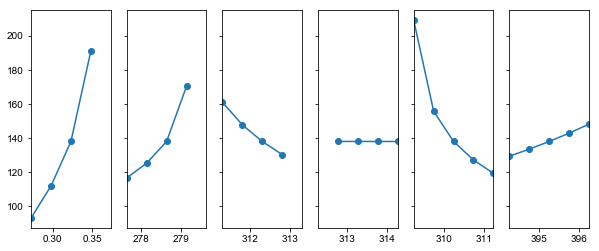

In [187]:
plt.close('all')
plt.figure(figsize=(10, 4))
ax1=plt.subplot(1,len(box), 1)
for i,_ in enumerate(box):
    ax=plt.subplot(1, len(box), i+1, sharey=ax1)
    xxx = x2[i] + ss * box[i]
    plt.plot(xxx, yyy[i,:], 'o-')
    plt.setp(ax.get_yticklabels(), visible=bool(i==0))
    plt.xlim(min(xxx),max(xxx))
#plt.ylim(min(yyy.flat)*0.9,min(yyy.flat))
plt.show()

The sensitivity plot could go further by overlaying the constraint functions. Additionally, it would be nice to find the eigenvectors of the objective function and trace in those directions, indicating how far it is to the next constraint. But that is icing on the cake, so meanwhile I will continue with this approach in a new notebook and generate some parametric study data.

# Scratch work

In [15]:
a=5
for i in range(9999):
    a*=0.5
    if a==0:
        break
i,a

(1076, 0.0)

In [25]:
gradient_step = numpy.array([1.,2.,3.,4.])
for j, _ in enumerate(gradient_step):
    for i in range(2):
        gradient_step[j] *= 0.5
gradient_step

array([ 0.25,  0.5 ,  0.75,  1.  ])

In [30]:
numpy.diag(gradient_step)[3]

array([ 0.,  0.,  0.,  1.])

In [3]:
%%html
<pre id="TOC-markdown">TOC will be here</pre>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').filter(":has(a)").map(function(){return "  ".repeat($(this).prop("tagName")[1]) + "- ["+$(this).text()+"](" + $(this).children().attr("href") + ")";}).get().join("\n")
    );
</script>